## TD N°2 explicabilité du dataset Boston Housing

1) Charger le dataset bostong_housing
   1) Disponible dans le folder 04_interpretable_ml/td/data/
   
2) Nettoyer votre jeu de données pour créer une régression linéaire et un random forest
   1) Tester d'ajouter des features log, quadratique, ...

3)Créer un modèle baseline linéaire et random forest

4) Interpréter le modèle linéaire

5) Tuner votre random forest

6) Interpréter globalement votre modèle meilleur modèle RF 
   1) Utiliser les PDP ou ALE & Permutation feature Importance 
   2) Comparer les résulats du random forest avec votre interprétation du modèle linéaire

6) Réaliser une explicabilité par individu
   1) En utilisant la méthode ICE (PDP individuelle)
   2) LIME (Model local pour expliquer une prédiction)
   3) SHAP watterfall plot (Contribution marginale de chaque variable dans la prédiction)

7) Réaliser une explicabilité par individu sur le modèle RF
- 1) ICE, le PDP est-il une bonne représentation des variables importantes de votre modèle?
- 2) LIME
- 3) SHAP watterfall plot

8) Explorer les graphiques SHAP étudiés  dans la partie CM
   1) beeswarm (Contribution des variables)
   2) scatter (équivalent pdp)

## Contexte du Dataset

Le Boston Housing Dataset est un ensemble de données couramment utilisé en apprentissage automatique et en statistique pour étudier les relations entre diverses caractéristiques socio-économiques et immobilières dans la ville de Boston.  
Il contient des informations sur des propriétés résidentielles et leur environnement, et est souvent utilisé pour prédire la valeur des maisons, un problème classique de régression.

**Variable dispo**: 
- CRIM : taux de criminalité par habitant par ville
- ZN : proportion de terrains résidentiels zonés pour des lots de plus de 25 000 pieds carrés
- INDUS : proportion de terrains commerciaux non commerciaux par ville
- CHAS : variable binaire indiquant la proximité de la rivière Charles (= 1 si la zone délimitée par la ville touche la rivière ; 0 sinon)
- NOX : concentration des oxydes d'azote (en parties par 10 millions)
- RM : nombre moyen de pièces par logement
- AGE : proportion des unités occupées par leur propriétaire et construites avant 1940
- DIS : distances pondérées vers cinq centres d'emploi de Boston
- RAD : indice d'accessibilité aux autoroutes radiales
- TAX : taux d'imposition foncière par valeur totale pour chaque tranche de 10 000 dollars
- PTRATIO : ratio élèves-enseignants par ville
- LSTAT : pourcentage de la population de statut socio-économique inférieur
- MEDV : valeur médiane des maisons occupées par leur propriétaire (en milliers de dollars) - **variable cible**

In [1]:
#Web request
import requests
import io
import pandas as pd
import numpy as np
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

/Users/rododo/opt/anaconda3/envs/SVM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1) Charger le dataset bostong_housing

In [2]:
url = "https://raw.githubusercontent.com/Roulitoo/cours_iae/master/04_INTERPRETABLE_ML/td/data/boston_housing.csv" 
download = requests.get(url).content

occupation = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=';')

In [3]:
occupation.sample(10)

,Unnamed: 0,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
205,205,0.13642,0.0,10.59,0,0.489,5.891,22.3,3.9454,4,277.0,18.6,10.87,22.6
495,495,0.17899,0.0,9.69,0,0.585,5.670,28.8,2.7986,6,391.0,19.2,17.60,23.1
197,197,0.04666,80.0,1.52,0,0.404,7.107,36.6,7.3090,2,329.0,12.6,8.61,30.3
289,289,0.04297,52.5,5.32,0,0.405,6.565,22.9,7.3172,6,293.0,16.6,9.51,24.8
274,274,0.05644,40.0,6.41,1,0.447,6.758,32.9,4.0776,4,254.0,17.6,3.53,32.4
223,223,0.61470,0.0,6.20,0,0.507,6.618,80.8,3.2721,8,307.0,17.4,7.60,30.1
139,139,0.54452,0.0,21.89,0,0.624,6.151,97.9,1.6687,4,437.0,21.2,18.46,17.8
208,208,0.13587,0.0,10.59,1,0.489,6.064,59.1,4.2392,4,277.0,18.6,14.66,24.4
325,325,0.19186,0.0,7.38,0,0.493,6.431,14.7,5.4159,5,287.0,19.6,5.08,24.6
215,215,0.19802,0.0,10.59,0,0.489,6.182,42.4,3.9454,4,277.0,18.6,9.47,25.0


### 2)Nettoyer votre jeu de données pour créer une régression linéaire et un random forest

Penser à :

- Vérifier comment encoder vos variables qualitatives pour la modélisation 
- Analyser les distributions
- Analyser les outliers 
- Analyser les corrélations

>Tester d'ajouter des features log, quadratique, ...

In [4]:
occupation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  506 non-null    int64  
 1   CRIM        506 non-null    float64
 2   ZN          506 non-null    float64
 3   INDUS       506 non-null    float64
 4   CHAS        506 non-null    int64  
 5   NOX         506 non-null    float64
 6   RM          506 non-null    float64
 7   AGE         506 non-null    float64
 8   DIS         506 non-null    float64
 9   RAD         506 non-null    int64  
 10  TAX         506 non-null    float64
 11  PTRATIO     506 non-null    float64
 12  LSTAT       506 non-null    float64
 13  MEDV        506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


Il existe 2 variables catégorielles dont une binaire que nous n'allons pas modifier (CHAS), tandis que pour la deuxième (RAD), nous vérifions son format d'encodage.

### Vérification des NA

In [6]:
na = occupation.isna()
print(na.sum())

Unnamed: 0    0
CRIM          0
ZN            0
INDUS         0
CHAS          0
NOX           0
RM            0
AGE           0
DIS           0
RAD           0
TAX           0
PTRATIO       0
LSTAT         0
MEDV          0
dtype: int64


Nous pouvons observer qu'il n'y a aucune valeur manquante dans la base de données, de ce fait nous pouvons continuer notre analyse exploratoire.

In [7]:
occupation.RAD.value_counts()

RAD
24    132
5     115
4     110
3      38
6      26
8      24
2      24
1      20
7      17
Name: count, dtype: int64

Nous décidons de supprimer l'index de cette donnée et de standardiser nos données afin de visualiser au mieux les distributions.

In [8]:
occupation_propres = occupation.drop('Unnamed: 0',axis = 1)

In [9]:
Cols_non_standard = ["RAD", "CHAS"]
Cols = [col for col in occupation_propres.columns if col not in Cols_non_standard]
scaler = StandardScaler()
data_standard = scaler.fit_transform(occupation_propres[Cols])
occupation_standard = occupation_propres.copy()
occupation_standard[Cols] = data_standard

### Visualisation de la distribution

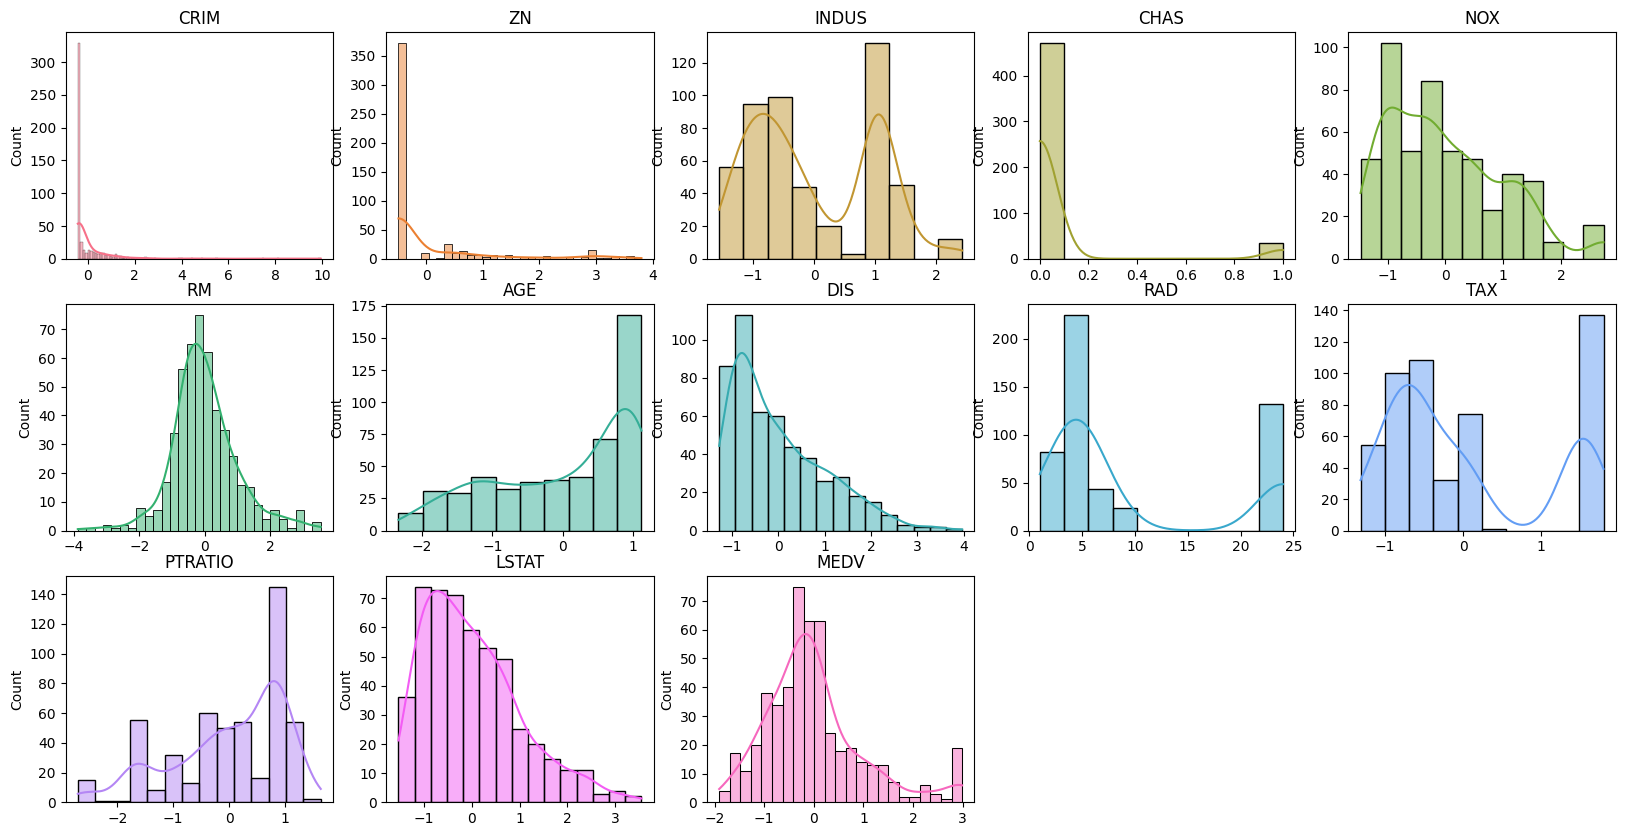

In [10]:
plt.figure(figsize=(20, 10))
colors = sns.color_palette("husl", len(occupation_standard.columns))
for i, column in enumerate(occupation_standard.columns):
    plt.subplot(3, 5, i+1)
    sns.histplot(occupation_standard[column], kde=True, color=colors[i])
    plt.xlabel("", fontsize=0)
    plt.title(column)

En étudiant ces histogrammes, nous pouvons observer plusieurs distributions. Au préalable de l'analyse, il est important de préciser que l'ensemble des données a été standardisé afin de pouvoir les analyser sur un même graphique. Ainsi, nous constatons que certaines distributions, comme CRIM, ZN et DIS, sont asymétriques : en effet, les valeurs sont concentrées vers la gauche avec de longues queues vers la droite, ce qui indique la potentielle présence de valeurs extrêmes. En revanche, les distributions de variables comme RM et AGE peuvent aisément être assimilées à des distributions normales. Cette visualisation nous permet dès lors de mieux comprendre la répartition des données. Cependant, afin d'obtenir une analyse plus rigoureuse, il est essentiel de la compléter avec une analyse des boîtes à moustaches.

### Visualisation des points atypiques

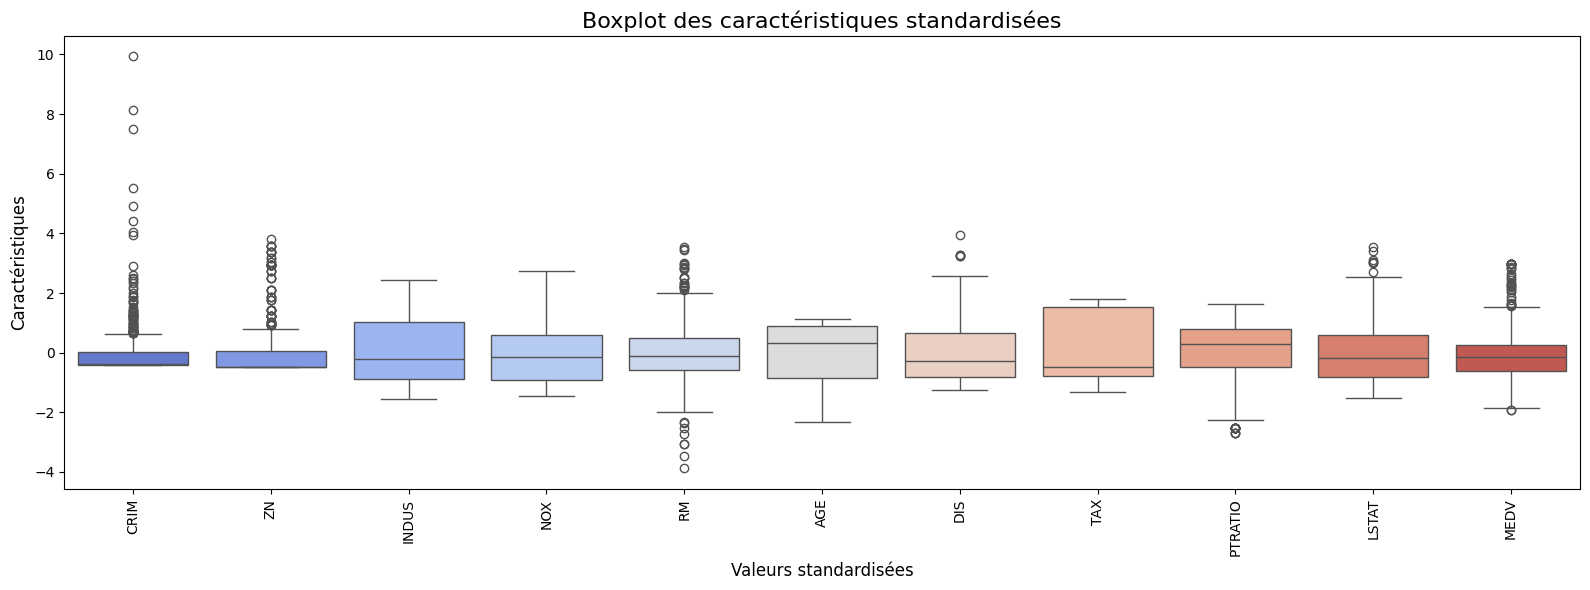

In [11]:
plt.figure(figsize=(16, 6))  # Taille de la figure
sns.boxplot(data=occupation_standard.drop(["RAD", "CHAS"], axis=1), palette="coolwarm")
plt.title("Boxplot des caractéristiques standardisées", fontsize=16)
plt.xlabel("Valeurs standardisées", fontsize=12)
plt.xticks(rotation = 90)
plt.ylabel("Caractéristiques", fontsize=12)
plt.tight_layout()
plt.show()

Cette visualisation des données sous forme de boîtes à moustaches permet de mettre directement en évidence les différentes valeurs aberrantes. Ainsi, pour CRIM, ZN, RM et LSTAT, de nombreux points se situent au-delà des limites des boîtes, ce qui révèle une dispersion importante de ces variables. Cela pourrait justifier l'utilisation de techniques de transformation, telles que la transformation logarithmique, afin de réduire l'impact des valeurs extrêmes.

In [12]:
def detect_outliers(df):
    outliers = {}
    
    for column in df.columns:
        # Calcul des quartiles
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    return outliers
points_atypiques = detect_outliers(occupation_standard)
# Afficher les outliers détectés pour chaque variable
for column, values in points_atypiques.items():
    print(f"Outliers pour {column}:")
    print(values[:2])
    print("\n")

Outliers pour CRIM:
         CRIM        ZN     INDUS  CHAS       NOX        RM       AGE  \
367  1.153105 -0.487722  1.015999     0  0.659147 -3.450002  1.117494   
371  0.653875 -0.487722  1.015999     0  0.659147 -0.097781  1.117494   

          DIS  RAD       TAX   PTRATIO     LSTAT      MEDV  
367 -1.085954   24  1.530926  0.806576  0.094889  0.061732  
371 -1.248292   24  1.530926  0.806576 -0.437772  2.989460  


Outliers pour ZN:
        CRIM        ZN     INDUS  CHAS       NOX        RM       AGE      DIS  \
39 -0.417302  2.731245 -1.194528     0 -1.094434  0.442165 -1.663342  0.76347   
40 -0.416608  2.731245 -1.194528     0 -1.094434  1.053344 -1.876706  0.76347   

    RAD       TAX   PTRATIO     LSTAT      MEDV  
39    3 -0.927937 -0.071913 -1.168077  0.899781  
40    3 -0.927937 -0.071913 -1.496084  1.346014  


Outliers pour INDUS:
Empty DataFrame
Columns: [CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, LSTAT, MEDV]
Index: []


Outliers pour CHAS:
        

Grâce à l'analyse des outliers, nous observons qu'il existe de nombreuses variables impactées par ces mêmes outliers, qui peuvent influencer les modèles d'analyse de données. Ainsi, nous pouvons observer des outliers pour la variable CRIM, par exemple, situés aux indices 367 et 371, avec des valeurs de CRIM égales à 1.153 et 0.654 respectivement, ce qui est supérieur à la moyenne de cette variable et pourrait indiquer des zones avec des taux de criminalité exceptionnels, contrairement à la variable TAX qui ne possède pas d'outliers. De ce fait, une transformation logarithmique de certaines variables paraît donc nécessaire. Cette transformation permet de réduire l'impact des valeurs extrêmes tout en préservant la structure des relations entre les variables. Nous décidons de l'appliquer sur un ensemble de 2 variables : CRIM et ZN

In [13]:
#Transformation log 
occupation_standard['CRIM'] = np.log(occupation_standard['CRIM'] + 1)
occupation_standard['ZN'] = np.log(occupation_standard['ZN'] + 1)

### Analyse de corrélation

In [14]:
correlation = occupation_standard.corr(method='spearman')
correlation.style.background_gradient(cmap='coolwarm')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT,MEDV
CRIM,1.000000,-0.571660,0.735524,0.041537,0.821465,-0.309116,0.704140,-0.744986,0.727807,0.729045,0.465283,0.634760,-0.558891
ZN,-0.571660,1.000000,-0.642811,-0.041937,-0.634828,0.361074,-0.544423,0.614627,-0.278767,-0.371394,-0.448475,-0.490074,0.438179
INDUS,0.735524,-0.642811,1.000000,0.089841,0.791189,-0.415301,0.679487,-0.757080,0.455507,0.664361,0.433710,0.638747,-0.578255
CHAS,0.041537,-0.041937,0.089841,1.000000,0.068426,0.058813,0.067792,-0.080248,0.024579,-0.044486,-0.136065,-0.050575,0.140612
NOX,0.821465,-0.634828,0.791189,0.068426,1.000000,-0.310344,0.795153,-0.880015,0.586429,0.649527,0.391309,0.636828,-0.562609
RM,-0.309116,0.361074,-0.415301,0.058813,-0.310344,1.000000,-0.278082,0.263168,-0.107492,-0.271898,-0.312923,-0.640832,0.633576
AGE,0.704140,-0.544423,0.679487,0.067792,0.795153,-0.278082,1.000000,-0.801610,0.417983,0.526366,0.355384,0.657071,-0.547562
DIS,-0.744986,0.614627,-0.757080,-0.080248,-0.880015,0.263168,-0.801610,1.000000,-0.495806,-0.574336,-0.322041,-0.564262,0.445857
RAD,0.727807,-0.278767,0.455507,0.024579,0.586429,-0.107492,0.417983,-0.495806,1.000000,0.704876,0.318330,0.394322,-0.346776
TAX,0.729045,-0.371394,0.664361,-0.044486,0.649527,-0.271898,0.526366,-0.574336,0.704876,1.000000,0.453345,0.534423,-0.562411


La matrice de corrélation ci-dessus nous permet de mieux comprendre les différentes relations au sein de notre base de données. Ainsi, pour notre variable cible "MEDV", nous pouvons observer qu'elle présente des corrélations fortes avec presque l'ensemble des variables (>|0.5|), telles qu'avec CRIM (-0.559), ce qui signifie que les zones ayant une criminalité élevée ont tendance à avoir une valeur médiane des maisons plus faible. De plus, nous pouvons également constater que la majorité de ces corrélations sont négatives, ce qui indique qu'une augmentation d'une variable ayant une corrélation négative avec MEDV entraîne une diminution de la valeur des maisons.

De plus, nous observons qu'il existe des corrélations importantes entre certaines variables indépendantes, comme entre INDUS et NOX (0.791). Cela indique que la proportion d'industries est fortement corrélée avec la concentration de NOX, suggérant que les zones industrielles présentent des niveaux de pollution plus élevés, ce qui pourrait affecter la qualité de l'air et les prix des maisons dans ces zones. Nous pouvons mettre ces résultats en contraste avec les variables faiblement corrélées entre elles, telles que RM et CHAS (-0.059), qui montrent une relation quasi inexistante.

### Encodage de la variable

In [15]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
occupation_standard['RAD'] = label_encoder.fit_transform(occupation_standard['RAD'])
occupation_standard.RAD.value_counts()

RAD
8    132
4    115
3    110
2     38
5     26
7     24
1     24
0     20
6     17
Name: count, dtype: int64

### 3)Créer 2 modèles baseline, linéaire et random forest

In [16]:
features = occupation_standard.drop(columns=['MEDV'])
target = occupation_standard['MEDV']

In [17]:
# Séparer les données en test et entraînement
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=22)

# Modèle de Régression Linéaire
Reg = LinearRegression()
Reg.fit(X_train, y_train)
y_pred_Reg = Reg.predict(X_test)

# Modèle de Random Forest
RF = RandomForestRegressor(random_state=42)
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_test)

In [18]:
#Calcule des divers indicateurs statistiques
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    mape = (abs((y_true - y_pred) / y_true).mean()) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"\n{model_name} Performance:")
    print(f"  - MSE: {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - MAE: {mae:.4f}")
    print(f"  - MAPE: {mape:.2f}%")
    print(f"  - R2 Score: {r2:.4f}")

# Évaluation des modèles
evaluate_model(y_test, y_pred_Reg, "Linear Regression")
evaluate_model(y_test, y_pred_RF, "Random Forest")


Linear Regression Performance:
  - MSE: 0.2687
  - RMSE: 0.5183
  - MAE: 0.4051
  - MAPE: 263.80%
  - R2 Score: 0.7442

Random Forest Performance:
  - MSE: 0.1705
  - RMSE: 0.4129
  - MAE: 0.2680
  - MAPE: 173.90%
  - R2 Score: 0.8377


Afin de comparer les deux modèles, nous avons décidé d'utiliser un ensemble d'indicateurs statistiques nous permettant ainsi de comparer et de choisir le modèle le plus adapté. Pour ce faire, nous utilisons des indicateurs que nous cherchons à maximiser, tels que le score R², et d'autres que nous cherchons à minimiser, tels que le MAPE et le MSE.

Ainsi, en étudiant ces résultats, nous pouvons observer que la Forêt Aléatoire semble surpasser la Régression Linéaire dans toutes les métriques de performance. Elle affiche des erreurs plus faibles (MSE, RMSE, MAE) et un meilleur ajustement global des données (R² plus élevé).

### 4) Interpréter le modèle linéaire
Utiliser les méthodes intrinsèques du modèle pour l'interprétation

In [19]:
#Coefficient du modèle linéaire
Coefficients = pd.DataFrame(Reg.coef_, features.columns, columns=['Coefficient'])
Constante = Reg.intercept_
print(f"\nConstante de la régression linéaire : {Constante}")
print(f"\nCoefficients de la régression linéaire :{Coefficients}")


Constante de la régression linéaire : -0.2182478201836373

Coefficients de la régression linéaire :         Coefficient
CRIM       -0.095654
ZN          0.135872
INDUS      -0.042975
CHAS        0.441499
NOX        -0.211413
RM          0.296997
AGE        -0.023310
DIS        -0.344954
RAD         0.049317
TAX        -0.053206
PTRATIO    -0.164326
LSTAT      -0.435544


Même si ce modèle n'est pas notre meilleur, l'analyse des différents coefficients de la régression linéaire nous permet de mieux comprendre les relations entre notre variable cible et les variables indépendantes, offrant ainsi une première étude significative.

Ainsi, nous observons des coefficients négatifs pour des variables telles que la criminalité (CRIM), la pollution (NOX), l'âge des maisons (AGE), la distance aux centres d'emploi (DIS), les taxes (TAX), le ratio élèves/enseignant (PTRATIO) et le statut socio-économique faible (LSTAT), qui sont associés à une diminution de la valeur des maisons. Cela suggère que des niveaux élevés de criminalité, de pollution, des maisons plus anciennes, ainsi qu'une population défavorisée, réduisent la valeur immobilière.

En revanche, des coefficients positifs sont observés pour des variables telles que la proportion de zones résidentielles (ZN), la proximité d'un cours d'eau (CHAS), et la taille des maisons (RM), qui sont associées à une augmentation de la valeur des maisons.

Ainsi, les facteurs environnementaux (criminalité, pollution), économiques (taxes, statut socio-économique) et physiques (taille des maisons, proximité de l'eau) influencent la valeur des maisons, ce qui est cohérent avec les attentes économiques et sociales classiques.

### 5) Tuner votre random forest

In [20]:
from sklearn.model_selection import GridSearchCV
#Définition des hyperparamétres
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
# Initialiser le modèle RandomForest
rf = RandomForestRegressor(random_state=42)

# Initialiser GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Exécuter GridSearchCV
grid_search.fit(X_train, y_train)

# Afficher les meilleurs hyperparamètres
print(f"Best parameters found: {grid_search.best_params_}")

Fitting 3 folds for each of 648 candidates, totalling 1944 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=300; tot

/Users/rododo/opt/anaconda3/envs/SVM/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
648 fits failed out of a total of 1944.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
368 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rododo/opt/anaconda3/envs/SVM/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rododo/opt/anaconda3/envs/SVM/lib/python3.9/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/Users/rododo/opt/anaconda3/envs/SVM/lib/python3.9/site-packages/sklearn/base.py", line 436, in _validate_pa

Best parameters found: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


Nous poursuivons notre analyse avec notre meilleur modèle, le Random Forest. Cependant, dans le but de l'améliorer davantage, nous avons choisi de le tuner. Ainsi, nous obtenons comme modèle final un modèle assez flexible, avec une profondeur d'arbre modérée (max_depth = 10) et une exploration étendue des caractéristiques (max_features = 'sqrt').

In [21]:
#Utilisation des meilleurs paramétres 
RF_tuné = grid_search.best_estimator_
y_pred_RF_tuné = RF_tuné.predict(X_test)
evaluate_model(y_test, y_pred_RF_tuné, "Random Forest tuné")
evaluate_model(y_test, y_pred_RF, "Random Forest")


Random Forest tuné Performance:
  - MSE: 0.1046
  - RMSE: 0.3234
  - MAE: 0.2131
  - MAPE: 114.78%
  - R2 Score: 0.9004

Random Forest Performance:
  - MSE: 0.1705
  - RMSE: 0.4129
  - MAE: 0.2680
  - MAPE: 173.90%
  - R2 Score: 0.8377


Nous utilisons les mêmes indicateurs qu'auparavant et obtenons ainsi que c'est bien le modèle tuné qui est le meilleur. De ce fait, nous utiliserons uniquement ce modèle pour l'interprétabilité.

### 6) Interpréter globalement votre modèle meilleur modèle RF 
   1) Utiliser les PDP ou ALE & Permutation feature Importance 
   2) Comparer les résulats du random forest avec votre interprétation du modèle linéaire

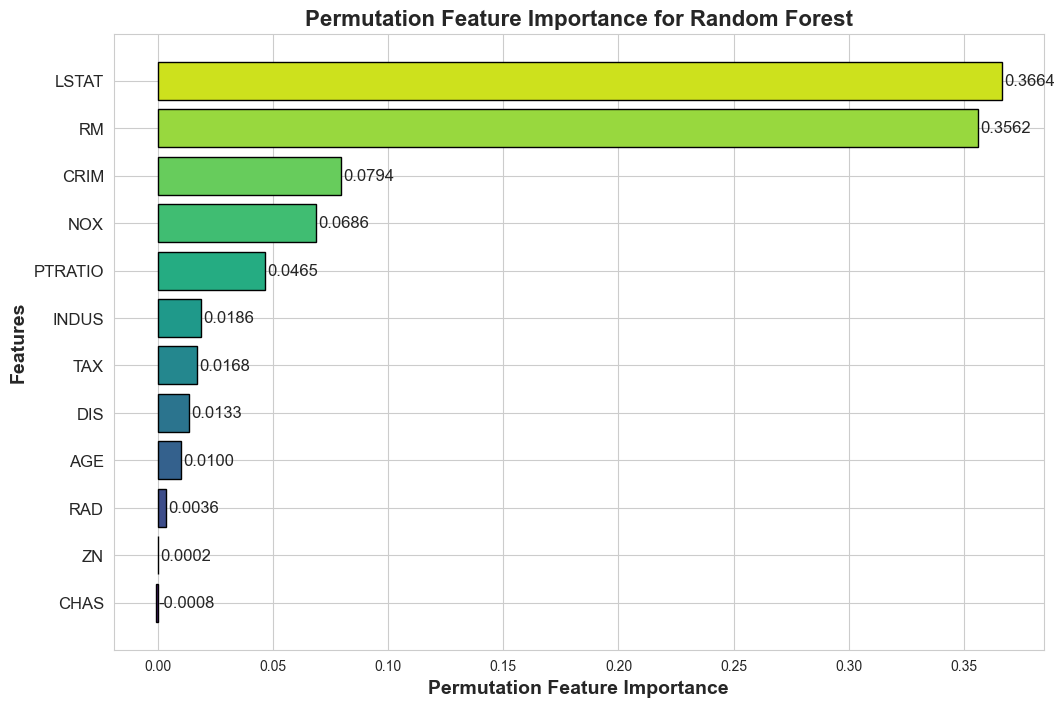

In [20]:
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
import numpy as np
sns.set_style("whitegrid")
result = permutation_importance(RF_tuné, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = np.argsort(result.importances_mean)
plt.figure(figsize=(12, 8))
plt.barh(
    np.arange(len(sorted_idx)), 
    result.importances_mean[sorted_idx], 
    align='center', 
    color=sns.color_palette("viridis", len(sorted_idx)),  # Palette de couleurs dynamiques
    edgecolor='black'
)
plt.yticks(np.arange(len(sorted_idx)), [X_test.columns[i] for i in sorted_idx], fontsize=12)
plt.xlabel('Permutation Feature Importance', fontsize=14, fontweight='bold')
plt.ylabel('Features', fontsize=14, fontweight='bold')
plt.title('Permutation Feature Importance for Random Forest', fontsize=16, fontweight='bold')
for i, v in enumerate(result.importances_mean[sorted_idx]):
    plt.text(v + 0.001, i, f"{v:.4f}", fontsize=12, verticalalignment="center")

plt.show()

À l'aide de ce graphique, nous pouvons étudier les différences d'importance de nos variables dans le modèle. Nous remarquons que l'importance relative des variables montre que LSTAT et RM sont les facteurs les plus influents. En effet, ces deux variables possèdent des scores respectifs de 0.3664 et 0.3562. Ces résultats démontrent que les quartiers avec une population plus modeste et le nombre de pièces sont des indicateurs clés pour la valeur médiane des maisons.

Par la suite, nous pouvons identifier trois autres variables, à savoir CRIM, NOX et PTRATIO, qui ont également une influence, mais de manière plus modérée. Enfin, le reste des variables ne semble pas avoir d'impact significatif sur MEDV. Ainsi, les dimensions socio-économiques, écologiques et structurelles de la maison et du quartier sont les variables ayant le plus d'impact sur la valeur médiane des maisons. 

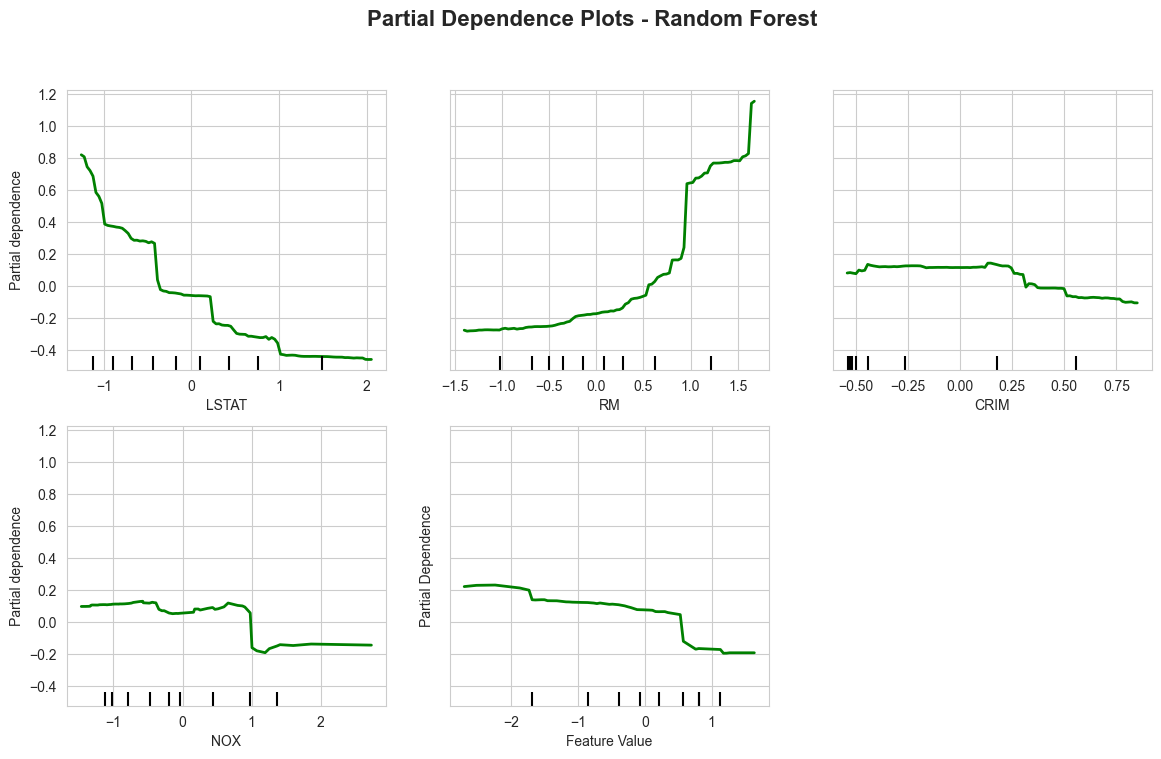

In [23]:
#PDP
from sklearn.inspection import PartialDependenceDisplay
sns.set_style("whitegrid")
features = ['LSTAT', 'RM', 'CRIM','NOX','PTRATIO']
fig, ax = plt.subplots(figsize=(14, 8))
display = PartialDependenceDisplay.from_estimator(
    RF_tuné, X_train, features, ax=ax, 
    line_kw={"color": "blue", "linewidth": 2},
    pd_line_kw={"color": "green", "linewidth": 2}
)
plt.suptitle('Partial Dependence Plots - Random Forest', fontsize=16, fontweight='bold')
plt.subplots_adjust(top=0.88)
plt.xlabel("Feature Value")
plt.ylabel("Partial Dependence")
plt.show()


Une fois l'importance des variables démontrée, nous pouvons passer à l'étude des 5 variables les plus importantes de notre modèle. Ainsi, nous allons analyser les Partial Dependence Plots, qui représentent l'effet marginal de chaque variable sur la prédiction du modèle, sous la contrainte du maintien des autres variables constantes.

Au vu des différents résultats, nous pouvons observer que LSTAT possède un effet fortement négatif, signifiant qu'un quartier modeste est associé à des valeurs médianes de maisons plus faibles que la variable cible. En revanche, la variable RM présente un effet positif fort, expliquant ainsi que plus il y a de pièces, plus la valeur médiane augmente.

Pour les trois autres variables, à savoir CRIM, NOX et PTRATIO, nous observons des effets moins significatifs sur la valeur de la maison, ces effets devenant notables uniquement au-delà d'un certain seuil. Par exemple, pour la variable CRIM, le graphique indique qu'à partir d'un certain seuil, l'augmentation de la criminalité peut avoir un impact significatif sur notre variable cible.

### 7) Réaliser une explicabilité par individu sur le modèle RF
- 1) ICE, le PDP est-il une bonne représentation des variables importantes de votre modèle?
- 2) LIME
- 3) SHAP watterfall plot

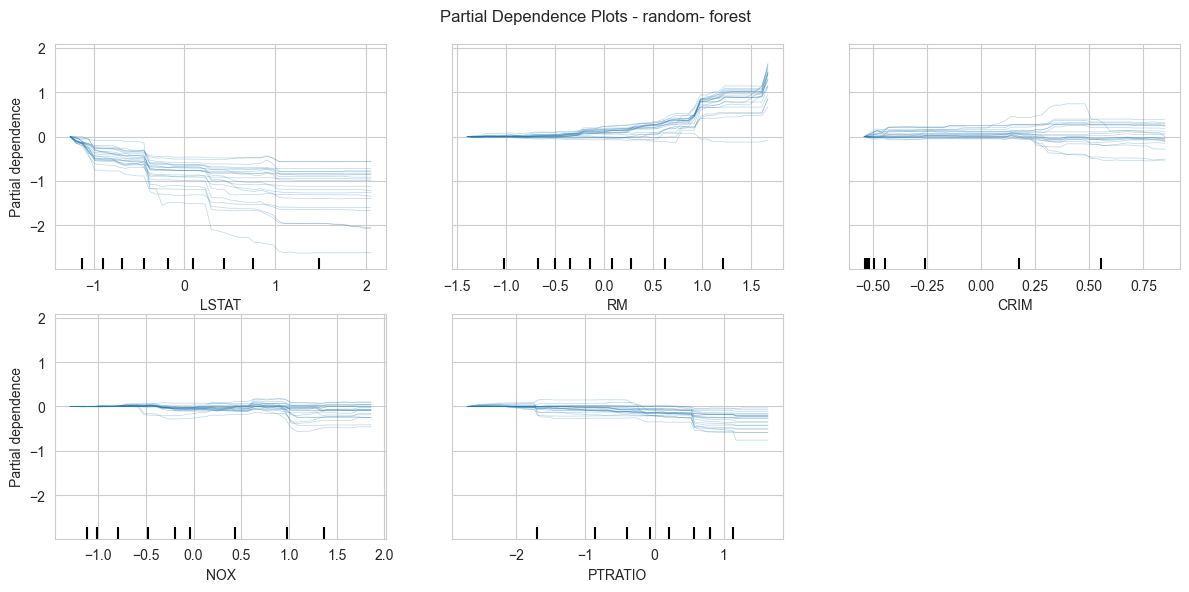

In [24]:
#ICE#
_, ax1 = plt.subplots(figsize = (12,6))
PartialDependenceDisplay.from_estimator(RF_tuné,
                                         X_train, 
                                         features, #Même features que avant
                                         kind="individual",
                                         ax = ax1,
                                         grid_resolution=50,
                                         n_cols=3,
                                         subsample=0.05, 
                                         centered=True
                                         )
plt.suptitle("Partial Dependence Plots - random- forest")
plt.tight_layout()
plt.show()

Ces graphiques nous permettent de comprendre l'évolution individuelle de chaque observation, contrairement aux PDP qui montrent l'évolution moyenne. Ainsi, ces visualisations graphiques nous aident à mieux comprendre l'évolution de chaque individu. Cependant, l'analyse effectuée précédemment pour la PDP est similaire pour ces graphiques. En effet, nous observons un effet fortement significatif pour LSTAT et un effet positif pour RM, ainsi que des effets moins significatifs qui n'agissent qu'à un certain seuil. Par conséquent, nous arrivons à la même conclusion, ce qui nous amène à appliquer d'autres visualisations pour mieux comprendre notre modèle.

In [27]:
#LIME
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns,
    mode="regression"
)
i = 22 
sample = X_test.iloc[i].values
model_prediction = RF_tuné.predict(sample.reshape(1, -1))
explanation = explainer.explain_instance(
    data_row=sample,
    predict_fn=RF_tuné.predict
)

#Affichage des résultats
explanation.show_in_notebook(show_table=True)

/Users/rododo/opt/anaconda3/envs/SVM/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/rododo/opt/anaconda3/envs/SVM/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


L'explication locale des prédictions pour un individu précis, dans notre cas l'individu 22, permet de mieux comprendre quelles variables ont eu un impact sur la prédiction. Tout d'abord, nous observons que la valeur prédite est de -0.01, dans un intervalle où les valeurs possibles varient de -1.12 à 2.38. Ensuite, nous analysons les différents facteurs influençant positivement et négativement la prédiction.

Nous constatons ainsi que la variable RM a contribué à la diminution de la prédiction, tandis que LSTAT a eu l'effet inverse en l'augmentant. Cette analyse confirme que les facteurs socio-économiques et environnementaux (LSTAT, NOX, DIS) jouent un rôle clé dans la prédiction. Cependant, afin de compléter cette étude avec plus de rigueur scientifique, nous utilisons également une approche SHAP, car les résultats obtenus avec LIME peuvent être biaisés en raison de son approximation locale, qui dépend fortement de l’échantillonnage utilisé.

In [25]:
#SHAP
# Définir le module explainer de Shap, attention ce n'est pas le même si c'est un modèle basé sur des abres
explainer = shap.TreeExplainer(RF_tuné)
shap_values = explainer(X_train.iloc[1:100])

#Visualisation
shap.initjs()
shap.force_plot(shap_values[22])

Cette analyse SHAP nous permet ainsi d’expliquer l’impact de chaque variable sur la prédiction en comparant leurs contributions individuelles par rapport à une valeur de base. Nous observons que la majorité des variables contribuent à l’augmentation de la prédiction, notamment LSTAT, qui a l’influence la plus forte, contrairement à RM, qui est la seule variable à faire baisser la prédiction.

Ces résultats nous mènent à la même conclusion que précédemment : la prédiction est principalement influencée par des facteurs environnementaux et fiscaux (TAX, NOX, INDUS), tandis que la qualité du logement (RM) tend à la réduire.

### 8) Explorer les graphiques SHAP étudiés  dans la partie CM
   1) beeswarm (Contribution des variables)
   2) scatter (équivalent pdp)

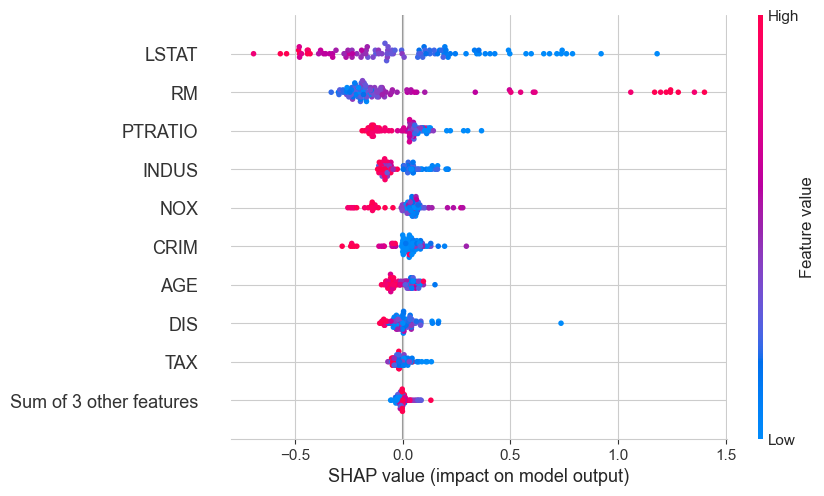

In [28]:
#1#
shap.plots.beeswarm(shap_values)

La visualisation à travers le Beeswarm plot permet d’analyser l’impact global des variables sur les prédictions du modèle. Chaque point représente une observation et illustre comment une variable spécifique influence la sortie du modèle. En étudiant les résultats obtenus, nous constatons que LSTAT et RM sont les variables les plus influentes. LSTAT a un impact positif sur la prédiction lorsque ses valeurs sont élevées, tandis que RM exerce un effet inverse, réduisant la prédiction lorsque sa valeur est plus importante. Toutefois, d’autres variables, telles que PTRATIO, INDUS et NOX, jouent également un rôle significatif. Ainsi, cette visualisation vient confirmer les résultats précédemment obtenus.

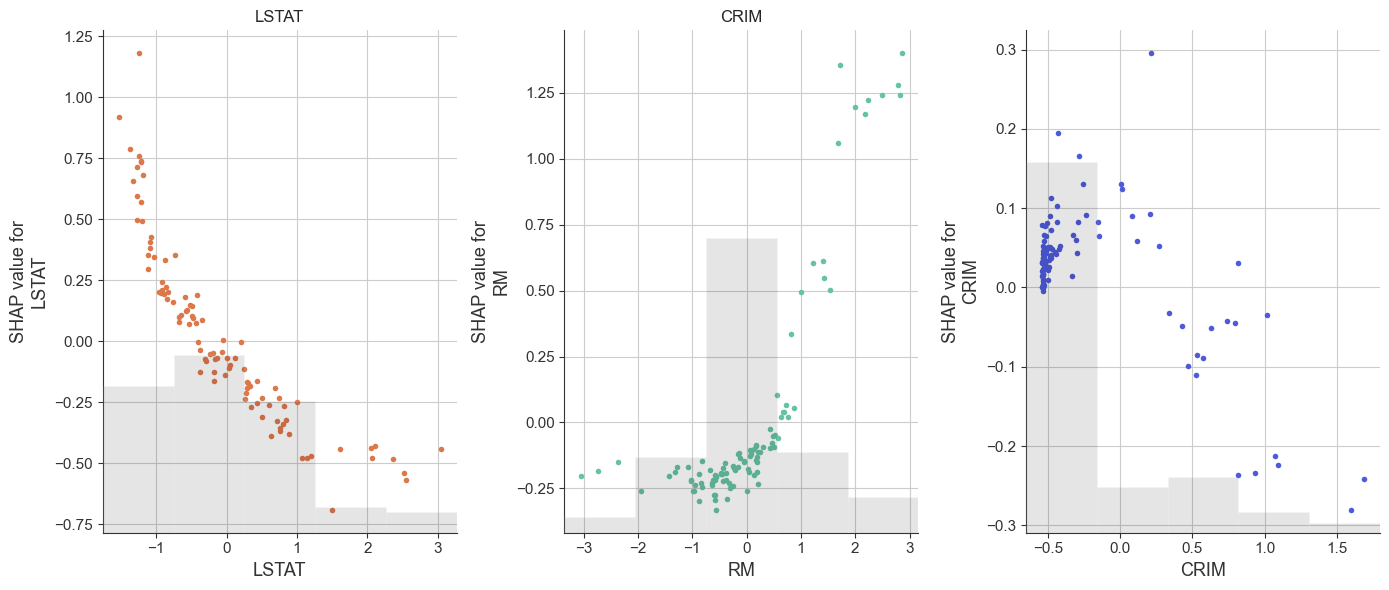

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

#Graphique SHAP pour 'LSTAT'
shap.plots.scatter(shap_values[:, 'LSTAT'], show=False, ax=axes[0])
axes[0].collections[0].set_facecolor('#dd784b') 
axes[0].set_title('LSTAT')

#Graphique SHAP pour 'RM'
shap.plots.scatter(shap_values[:, 'RM'], show=False, ax=axes[1])
axes[1].collections[0].set_facecolor('#66c2a5')  
axes[1].set_title('RM')

#Graphique SHAP pour 'CRIM'
shap.plots.scatter(shap_values[:, 'CRIM'], show=False, ax=axes[2])
axes[2].collections[0].set_facecolor('#4d5bdb')  
axes[1].set_title('CRIM')


plt.tight_layout()
plt.show()

Cette visualisation équivaut à une analyse par Partial Dependence Plots (PDP), impliquant que l’interprétation des résultats reste la même que celle formulée précédemment.